In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, 
    BatchNormalization, Input, Activation
)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, 
    ModelCheckpoint, TensorBoard, LearningRateScheduler
)
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns
import zipfile
import shutil

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [2]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [3]:
# Create directories
os.makedirs('./models/', exist_ok=True)
os.makedirs('./plots/loss/', exist_ok=True)
os.makedirs('./plots/accuracy/', exist_ok=True)
os.makedirs('./logs/', exist_ok=True)

In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


## Dataset Configuration - Grayscale Mode

In [5]:
# RAF-DB Dataset Configuration for Grayscale
root_data_dir = r"C:\Users\maria\OneDrive\Desktop\RAF-DB\combined"

# GRAYSCALE: 64×64×1 (larger size possible due to memory savings)
img_width, img_height = 64, 64
channels = 1  # Grayscale

# RAF-DB Label mapping
RAFDB_LABEL_MAP = {
    'positive': 'positive',
    'negative': 'negative', 
    'neutral': 'neutral'
}

print(f"Dataset path: {root_data_dir}")
print(f"Image size: {img_width}×{img_height}×{channels} (GRAYSCALE)")
print(f"Classes: {list(RAFDB_LABEL_MAP.values())}")

Dataset path: C:\Users\maria\OneDrive\Desktop\RAF-DB\combined
Image size: 64×64×1 (GRAYSCALE)
Classes: ['positive', 'negative', 'neutral']


## Data Augmentation - Grayscale Optimized

In [6]:
# Grayscale preprocessing: normalize to [-1, 1]
def grayscale_preprocess(x):
    """Normalize grayscale images to [-1, 1] range"""
    return x / 127.5 - 1.0

# Training data augmentation - Enhanced for better accuracy
train_datagen = ImageDataGenerator(
    preprocessing_function=grayscale_preprocess,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=10,
    fill_mode='nearest'
)

# Test data - no augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function=grayscale_preprocess
)


In [7]:
# Create dataset dataframe
def create_rafdb_dataframe(root_data_dir, label_map):
    data = []
    label_names = set(label_map.values())
    
    for split in ['train', 'test']:
        split_path = os.path.join(root_data_dir, split)
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} not found!")
            continue
            
        for label_name in label_names:
            class_dir = os.path.join(split_path, label_name)
            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} not found!")
                continue
                
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    data.append({
                        'file_path': os.path.join(class_dir, image_name),
                        'label': label_name
                    })
    
    df = pd.DataFrame(data)
    print(f"\nDataset Summary:")
    print(f"Total images: {len(df)}")
    print("\nClass distribution:")
    print(df['label'].value_counts())
    return df
    
image_dataframe = create_rafdb_dataframe(root_data_dir, RAFDB_LABEL_MAP)
num_classes = len(RAFDB_LABEL_MAP)


Dataset Summary:
Total images: 16872

Class distribution:
label
negative    6000
positive    5959
neutral     4913
Name: count, dtype: int64


In [8]:
# With Pretrained ImageNet Weights
# Converting RGB weights to grayscale

base_model_rgb = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3),
    alpha=0.35 
)

input_layer = Input(shape=(img_width, img_height, 1), name='grayscale_input')

base_model_gray = MobileNetV2(
    weights=None,  # Will manually set weights
    include_top=False,
    input_tensor=input_layer,
    alpha=0.35  
)



# Find the first Conv2D layer in both models
first_conv_rgb = None
first_conv_gray = None

for layer in base_model_rgb.layers:
    if 'Conv2D' in str(type(layer)) or 'conv' in layer.name.lower():
        first_conv_rgb = layer
        break

for layer in base_model_gray.layers:
    if 'Conv2D' in str(type(layer)) or 'conv' in layer.name.lower():
        first_conv_gray = layer
        break

if first_conv_rgb and first_conv_gray:
    # Get RGB weights: shape (kernel_h, kernel_w, 3, filters)
    rgb_weights = first_conv_rgb.get_weights()
    conv_weights_rgb = rgb_weights[0]  # Convolutional weights
    
    # Average across RGB channels to get grayscale weights
    # Shape: (kernel_h, kernel_w, 3, filters) -> (kernel_h, kernel_w, 1, filters)
    conv_weights_gray = np.mean(conv_weights_rgb, axis=2, keepdims=True)
    
    # Set grayscale weights
    if len(rgb_weights) > 1:  # Has bias
        first_conv_gray.set_weights([conv_weights_gray, rgb_weights[1]])
    else:
        first_conv_gray.set_weights([conv_weights_gray])
    


layers_copied = 0

for gray_layer, rgb_layer in zip(base_model_gray.layers[1:], base_model_rgb.layers[1:]):
    try:
        if len(rgb_layer.get_weights()) > 0:
            gray_layer.set_weights(rgb_layer.get_weights())
            layers_copied += 1
    except:
        pass  # Skip if shapes don't match




base_model_gray.trainable = True  # Fine-tune entire model

x = base_model_gray.output
x = GlobalAveragePooling2D(name='global_avg_pool')(x)
x = Dense(16, kernel_regularizer=l2(0.005), name='dense_16')(x)
x = BatchNormalization(name='batch_norm')(x)
x = Activation('relu', name='relu')(x)
x = Dropout(0.3, name='dropout')(x)
output_layer = Dense(num_classes, activation='softmax', name='output')(x)

model = Model(inputs=input_layer, outputs=output_layer, name='grayscale_emotion_alpha05_pretrained')

# Compile with Adam optimizer and label smoothing
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])



C:\Users\maria\AppData\Local\Temp\ipykernel_28356\3004279977.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_rgb = MobileNetV2(


## Train/Validation Split

In [9]:
# Split data into train and validation (80/20)
train_data, test_data = train_test_split(
    image_dataframe, 
    test_size=0.2, 
    random_state=SEED,
    stratify=image_dataframe['label']
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(test_data)}")
print(f"\nTraining class distribution:")
print(train_data['label'].value_counts())
print(f"\nValidation class distribution:")
print(test_data['label'].value_counts())

Training samples: 13497
Validation samples: 3375

Training class distribution:
label
negative    4800
positive    4767
neutral     3930
Name: count, dtype: int64

Validation class distribution:
label
negative    1200
positive    1192
neutral      983
Name: count, dtype: int64


## Training with Cosine Learning Rate Schedule

In [10]:
# Cosine learning rate schedule
import math

def cosine_decay(epoch, initial_lr=0.001, total_epochs=100):
    return initial_lr * 0.5 * (1 + math.cos(math.pi * epoch / total_epochs))

lr_scheduler = LearningRateScheduler(lambda epoch: cosine_decay(epoch, 0.001, 100), verbose=1)



In [11]:
# Create data generators with GRAYSCALE mode
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='file_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_data['label']),
    y=train_data['label']
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"  Training batches: {len(train_generator)}")
print(f"  Validation batches: {len(test_generator)}")
print(f"  Class weights: {class_weight_dict}")

Found 13497 validated image filenames belonging to 3 classes.
Found 3375 validated image filenames belonging to 3 classes.
  Training batches: 422
  Validation batches: 106
  Class weights: {0: np.float64(0.9372916666666666), 1: np.float64(1.1447837150127227), 2: np.float64(0.9437801552338997)}


In [12]:
# Training callbacks
callbacks = [
    lr_scheduler,
    EarlyStopping(
        monitor='val_accuracy',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='./models/best_grayscale_model.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir='./logs/grayscale_training')
]


In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=max(1, test_generator.samples // test_generator.batch_size),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4714 - loss: 1.2327
Epoch 1: val_accuracy improved from None to 0.31994, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 930s 2s/step - accuracy: 0.5249 - loss: 1.1155 - val_accuracy: 0.3199 - val_loss: 2.3326 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009997532801828658.
Epoch 2/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.6875 - loss: 0.8085

c:\Users\maria\OneDrive\Desktop\RL\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.31994 to 0.32054, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6875 - loss: 0.8085 - val_accuracy: 0.3205 - val_loss: 2.3285 - learning_rate: 9.9975e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009990133642141358.
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6120 - loss: 0.9075
Epoch 3: val_accuracy improved from 0.32054 to 0.51964, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.6311 - loss: 0.8725 - val_accuracy: 0.5196 - val_loss: 1.7599 - learning_rate: 9.9901e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00099778098230154.
Epoch 4/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.6250 - loss: 0.9514
Epoch 4: val_accuracy did not improve from 0.51964
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6250 - loss: 0.9514 - val_accuracy: 0.5188 - val_loss: 1.7330 - learning_rate: 9.9778e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000996057350657239.
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6556 - loss: 0.8139
Epoch 5: val_accuracy improved from 0.51964 to 0.58155, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.6622 - loss: 0.8007 - val_accuracy: 0.5815 - val_loss: 1.3175 - learning_rate: 9.9606e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0009938441702975688.
Epoch 6/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.7812 - loss: 0.5836
Epoch 6: val_accuracy did not improve from 0.58155
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7812 - loss: 0.5836 - val_accuracy: 0.5795 - val_loss: 1.3032 - learning_rate: 9.9384e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0009911436253643444.
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6822 - loss: 0.7665
Epoch 7: val_accuracy improved from 0.58155 to 0.59286, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.6863 - loss: 0.7580 - val_accuracy: 0.5929 - val_loss: 1.2349 - learning_rate: 9.9114e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0009879583809693738.
Epoch 8/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.6250 - loss: 0.7190
Epoch 8: val_accuracy did not improve from 0.59286
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6250 - loss: 0.7190 - val_accuracy: 0.5884 - val_loss: 1.2566 - learning_rate: 9.8796e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0009842915805643156.
Epoch 9/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6911 - loss: 0.7404
Epoch 9: val_accuracy improved from 0.59286 to 0.63304, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.6993 - loss: 0.7297 - val_accuracy: 0.6330 - val_loss: 1.2130 - learning_rate: 9.8429e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0009801468428384716.
Epoch 10/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.6562 - loss: 0.7649
Epoch 10: val_accuracy did not improve from 0.63304
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6562 - loss: 0.7649 - val_accuracy: 0.6318 - val_loss: 1.2188 - learning_rate: 9.8015e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0009755282581475768.
Epoch 11/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7035 - loss: 0.7066
Epoch 11: val_accuracy improved from 0.63304 to 0.66994, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.7019 - loss: 0.7143 - val_accuracy: 0.6699 - val_loss: 0.9770 - learning_rate: 9.7553e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0009704403844771128.
Epoch 12/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.5938 - loss: 1.1734
Epoch 12: val_accuracy improved from 0.66994 to 0.67292, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 1.1734 - val_accuracy: 0.6729 - val_loss: 0.9791 - learning_rate: 9.7044e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0009648882429441257.
Epoch 13/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7066 - loss: 0.7191
Epoch 13: val_accuracy did not improve from 0.67292
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.7162 - loss: 0.7035 - val_accuracy: 0.6193 - val_loss: 1.2117 - learning_rate: 9.6489e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0009588773128419905.
Epoch 14/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.7188 - loss: 0.7861
Epoch 14: val_accuracy did not improve from 0.67292
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.7861 - val_accuracy: 0.6179 - val_loss: 1.2149 - learning_rate: 9.5888e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0009524135262330098.
Epoch 15/100
421/421 ━━━━━━━━━━━━━━━━

421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.7349 - loss: 0.6575 - val_accuracy: 0.7268 - val_loss: 0.8464 - learning_rate: 9.0451e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0008950775061878452.
Epoch 22/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.7188 - loss: 0.7622
Epoch 22: val_accuracy did not improve from 0.72679
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7188 - loss: 0.7622 - val_accuracy: 0.7223 - val_loss: 0.8474 - learning_rate: 8.9508e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0008852566213878947.
Epoch 23/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7301 - loss: 0.6607
Epoch 23: val_accuracy improved from 0.72679 to 0.74077, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.7363 - loss: 0.6549 - val_accuracy: 0.7408 - val_loss: 1.1313 - learning_rate: 8.8526e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0008750555348152298.
Epoch 24/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.5625 - loss: 0.7499
Epoch 24: val_accuracy improved from 0.74077 to 0.74464, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5625 - loss: 0.7499 - val_accuracy: 0.7446 - val_loss: 1.1061 - learning_rate: 8.7506e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0008644843137107057.
Epoch 25/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7352 - loss: 0.6494
Epoch 25: val_accuracy did not improve from 0.74464
421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.7364 - loss: 0.6547 - val_accuracy: 0.6824 - val_loss: 1.0995 - learning_rate: 8.6448e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0008535533905932737.
Epoch 26/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.7500 - loss: 0.6990
Epoch 26: val_accuracy did not improve from 0.74464
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7500 - loss: 0.6990 - val_accuracy: 0.6836 - val_loss: 1.1052 - learning_rate: 8.5355e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0008422735529643444.
Epoch 27/100
421/421 ━━━━━━━━━━━━━━━━

421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.7438 - loss: 0.6338 - val_accuracy: 0.7491 - val_loss: 0.7402 - learning_rate: 8.1871e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0008064535268264883.
Epoch 30/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.6562 - loss: 0.9110
Epoch 30: val_accuracy did not improve from 0.74911
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6562 - loss: 0.9110 - val_accuracy: 0.7491 - val_loss: 0.7373 - learning_rate: 8.0645e-04

Epoch 31: LearningRateScheduler setting learning rate to 0.0007938926261462367.
Epoch 31/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7494 - loss: 0.6258
Epoch 31: val_accuracy did not improve from 0.74911
421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.7425 - loss: 0.6351 - val_accuracy: 0.6244 - val_loss: 0.9634 - learning_rate: 7.9389e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0007810416889260654.
Epoch 32/100
  1/421 ━━━━━━━━━━━━━━

421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.7556 - loss: 0.6112 - val_accuracy: 0.7625 - val_loss: 0.6281 - learning_rate: 6.8406e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006693689601226458.
Epoch 40/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.6875 - loss: 0.6711
Epoch 40: val_accuracy did not improve from 0.76250
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6875 - loss: 0.6711 - val_accuracy: 0.7604 - val_loss: 0.6337 - learning_rate: 6.6937e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0006545084971874737.
Epoch 41/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7581 - loss: 0.6001
Epoch 41: val_accuracy improved from 0.76250 to 0.77024, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.7543 - loss: 0.6033 - val_accuracy: 0.7702 - val_loss: 0.6034 - learning_rate: 6.5451e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0006394955530196147.
Epoch 42/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.7188 - loss: 0.5928
Epoch 42: val_accuracy did not improve from 0.77024
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7188 - loss: 0.5928 - val_accuracy: 0.7690 - val_loss: 0.6066 - learning_rate: 6.3950e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0006243449435824273.
Epoch 43/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7652 - loss: 0.5838
Epoch 43: val_accuracy did not improve from 0.77024
421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.7637 - loss: 0.5844 - val_accuracy: 0.7649 - val_loss: 0.5949 - learning_rate: 6.2434e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0006090716206982714.
Epoch 44/100
  1/421 ━━━━━━━━━━━━━━

421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.7679 - loss: 0.5835 - val_accuracy: 0.7705 - val_loss: 0.5886 - learning_rate: 5.6267e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0005470541566592571.
Epoch 48/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.6875 - loss: 0.5855
Epoch 48: val_accuracy improved from 0.77054 to 0.77173, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6875 - loss: 0.5855 - val_accuracy: 0.7717 - val_loss: 0.5864 - learning_rate: 5.4705e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0005313952597646568.
Epoch 49/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7590 - loss: 0.5963
Epoch 49: val_accuracy improved from 0.77173 to 0.77708, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.7628 - loss: 0.5952 - val_accuracy: 0.7771 - val_loss: 0.5547 - learning_rate: 5.3140e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0005157053795390641.
Epoch 50/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.8750 - loss: 0.5501
Epoch 50: val_accuracy improved from 0.77708 to 0.77827, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8750 - loss: 0.5501 - val_accuracy: 0.7783 - val_loss: 0.5527 - learning_rate: 5.1571e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0005.
Epoch 51/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7654 - loss: 0.5957
Epoch 51: val_accuracy did not improve from 0.77827
421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.7707 - loss: 0.5763 - val_accuracy: 0.7527 - val_loss: 0.5911 - learning_rate: 5.0000e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.00048429462046093585.
Epoch 52/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.8750 - loss: 0.3131
Epoch 52: val_accuracy did not improve from 0.77827
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8750 - loss: 0.3131 - val_accuracy: 0.7527 - val_loss: 0.5933 - learning_rate: 4.8429e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0004686047402353433.
Epoch 53/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/s

421/421 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.7729 - loss: 0.5698 - val_accuracy: 0.7824 - val_loss: 0.5422 - learning_rate: 4.6860e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.00045294584334074284.
Epoch 54/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.7500 - loss: 0.6423
Epoch 54: val_accuracy did not improve from 0.78244
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.6423 - val_accuracy: 0.7824 - val_loss: 0.5461 - learning_rate: 4.5295e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.00043733338321784795.
Epoch 55/100
420/421 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7793 - loss: 0.5659
Epoch 55: val_accuracy improved from 0.78244 to 0.78333, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.7813 - loss: 0.5648 - val_accuracy: 0.7833 - val_loss: 0.5756 - learning_rate: 4.3733e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0004217827674798846.
Epoch 56/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.8125 - loss: 0.6651
Epoch 56: val_accuracy improved from 0.78333 to 0.78363, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8125 - loss: 0.6651 - val_accuracy: 0.7836 - val_loss: 0.5757 - learning_rate: 4.2178e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0004063093427071377.
Epoch 57/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7741 - loss: 0.5662
Epoch 57: val_accuracy improved from 0.78363 to 0.78512, saving model to ./models/best_grayscale_model.h5


421/421 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.7767 - loss: 0.5571 - val_accuracy: 0.7851 - val_loss: 0.5179 - learning_rate: 4.0631e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003909283793017289.
Epoch 58/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.7812 - loss: 0.4864
Epoch 58: val_accuracy did not improve from 0.78512
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7812 - loss: 0.4864 - val_accuracy: 0.7851 - val_loss: 0.5171 - learning_rate: 3.9093e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00037565505641757257.
Epoch 59/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7844 - loss: 0.5491
Epoch 59: val_accuracy did not improve from 0.78512
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.7766 - loss: 0.5586 - val_accuracy: 0.7485 - val_loss: 0.5926 - learning_rate: 3.7566e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0003605044469803854.
Epoch 60/100
  1/421 ━━━━━━━━━━━━━

421/421 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.7988 - loss: 0.5135 - val_accuracy: 0.7875 - val_loss: 0.5120 - learning_rate: 1.3552e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.00012494446518477025.
Epoch 78/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.8438 - loss: 0.3991
Epoch 78: val_accuracy did not improve from 0.78750
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8438 - loss: 0.3991 - val_accuracy: 0.7872 - val_loss: 0.5127 - learning_rate: 1.2494e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.00011474337861210544.
Epoch 79/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8023 - loss: 0.5114
Epoch 79: val_accuracy did not improve from 0.78750
421/421 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.8010 - loss: 0.5157 - val_accuracy: 0.7845 - val_loss: 0.5254 - learning_rate: 1.1474e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.00010492249381215479.
Epoch 80/100
  1/421 ━━━━━━━━━━━

421/421 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.8007 - loss: 0.5031 - val_accuracy: 0.7991 - val_loss: 0.4997 - learning_rate: 7.7836e-05

Epoch 84: LearningRateScheduler setting learning rate to 6.962898649802813e-05.
Epoch 84/100
  1/421 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step - accuracy: 0.8750 - loss: 0.3021
Epoch 84: val_accuracy did not improve from 0.79911
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8750 - loss: 0.3021 - val_accuracy: 0.7991 - val_loss: 0.4998 - learning_rate: 6.9629e-05

Epoch 85: LearningRateScheduler setting learning rate to 6.184665997806821e-05.
Epoch 85/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7992 - loss: 0.5105
Epoch 85: val_accuracy did not improve from 0.79911
421/421 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.7989 - loss: 0.5087 - val_accuracy: 0.7801 - val_loss: 0.5248 - learning_rate: 6.1847e-05

Epoch 86: LearningRateScheduler setting learning rate to 5.449673790581611e-05.
Epoch 86/100
  1/421 ━━━━━━━━━━━━━━

## Evaluation and Metrics

In [14]:
# Evaluate the model
from tensorflow.keras.models import load_model


best_model = load_model('./models/best_grayscale_model.h5')

# Get predictions
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Calculate metrics
accuracy = np.max(history.history['val_accuracy'])
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Validation Accuracy: 0.7991
F1 Score: 0.8013
Precision: 0.8059
Recall: 0.7994
              precision    recall  f1-score   support

    negative       0.79      0.76      0.77      1200
     neutral       0.70      0.79      0.74       983
    positive       0.91      0.85      0.88      1192

    accuracy                           0.80      3375
   macro avg       0.80      0.80      0.80      3375
weighted avg       0.81      0.80      0.80      3375



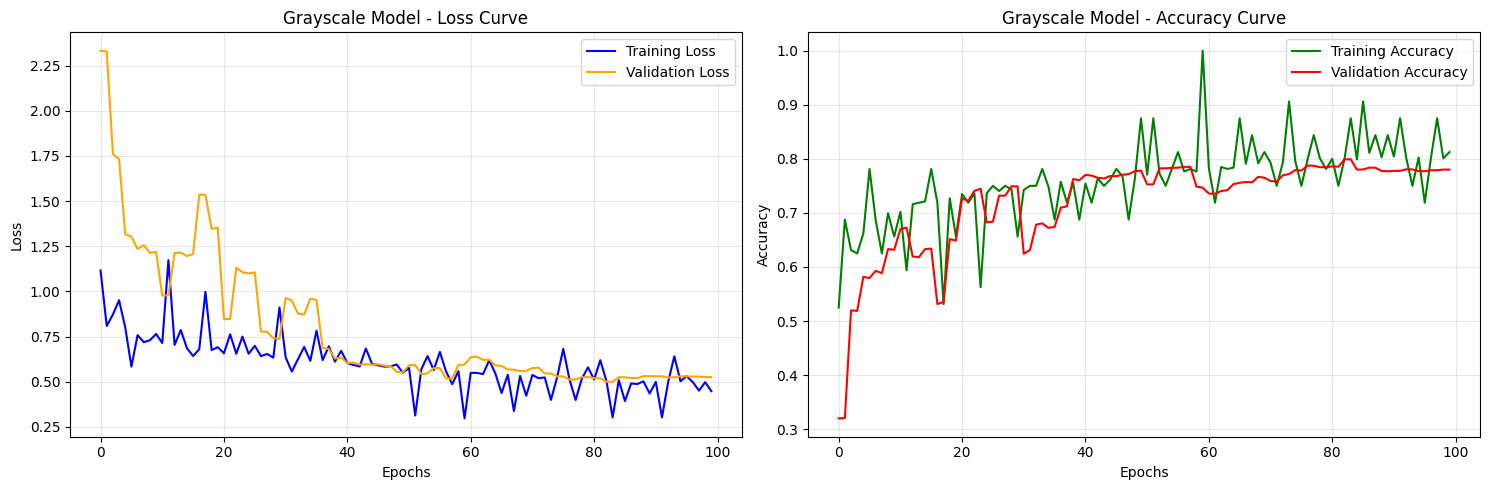

In [15]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Grayscale Model - Loss Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='green')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Grayscale Model - Accuracy Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/grayscale_training_curves.png', dpi=150)
plt.show()


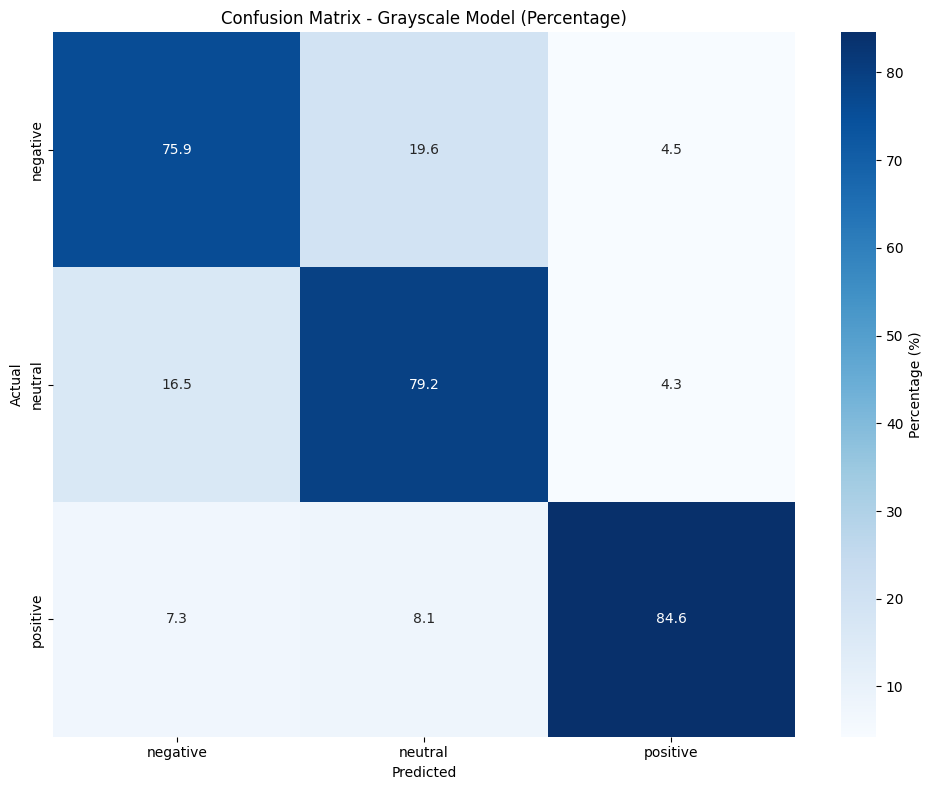

In [16]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_percent = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(),
            cbar_kws={'label': 'Percentage (%)'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Grayscale Model (Percentage)')
plt.tight_layout()
plt.savefig('./plots/grayscale_confusion_matrix.png', dpi=150)
plt.show()


In [17]:
# Extract grayscale validation images for Edge Impulse quantization
print("Extracting grayscale validation images for Edge Impulse...")

from tensorflow.keras.preprocessing import image as keras_image


val_images_gray = []
val_labels_gray = []

# Get class to index mapping
class_labels = sorted(test_data['label'].unique())
class_to_idx = {label: idx for idx, label in enumerate(class_labels)}

# Extract samples
max_samples = min(500, len(test_data))
sample_data = test_data.head(max_samples)


for idx, row in sample_data.iterrows():
    # Load image as GRAYSCALE (1 channel)
    img = keras_image.load_img(
        row['file_path'], 
        target_size=(img_width, img_height),
        color_mode='grayscale'  # KEY: Load as grayscale
    )
    img_array = keras_image.img_to_array(img)
    
    # Apply same preprocessing as training
    img_array = grayscale_preprocess(img_array)
    
    val_images_gray.append(img_array)
    
    # Create one-hot encoded label
    label_idx = class_to_idx[row['label']]
    one_hot = np.zeros(num_classes)
    one_hot[label_idx] = 1
    val_labels_gray.append(one_hot)
    
    if (idx + 1) % 50 == 0:
        print(f"Loaded {idx + 1}/{max_samples} images...", end='\r')

# Convert to numpy arrays
val_images_gray = np.array(val_images_gray, dtype=np.float32)
val_labels_gray = np.array(val_labels_gray, dtype=np.float32)

# Save as .npy file for Edge Impulse
images_path_gray = './models/grayscale_validation_images.npy'
labels_path_gray = './models/grayscale_validation_labels.npy'

np.save(images_path_gray, val_images_gray)
np.save(labels_path_gray, val_labels_gray)

Extracting grayscale validation images for Edge Impulse...


## Save Model in Multiple Formats

In [18]:
# Save in multiple formats for deployment

# 1. Keras format
keras_model_path = './models/grayscale_emotion_model.keras'
best_model.save(keras_model_path)


# 2. SavedModel format
savedmodel_path = './models/grayscale_savedmodel'
if os.path.exists(savedmodel_path):
    shutil.rmtree(savedmodel_path)
best_model.export(savedmodel_path)


# 3. Zip for Edge Impulse
zip_path = './models/grayscale_model.zip'
if os.path.exists(zip_path):
    os.remove(zip_path)

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(savedmodel_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, savedmodel_path)
            zipf.write(file_path, arcname)



# Save validation data
test_data.to_csv('grayscale_validation_data.csv', index=False)


INFO:tensorflow:Assets written to: ./models/grayscale_savedmodel\assets


INFO:tensorflow:Assets written to: ./models/grayscale_savedmodel\assets


Saved artifact at './models/grayscale_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='grayscale_input')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2602362269776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362267088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362267280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362267472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362269392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362269584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362268048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362268432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362266704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362270352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2602362266512: Tenso